In [1]:
import os

from lungmask import mask
import SimpleITK as sitk
import pydicom as dicom

dicom.config.use_DS_numpy= True

import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import MinMaxScaler

import skimage

import scipy

from datetime import datetime
from datetime import timedelta

In [2]:
dicomdir = 'osic-pulmonary-fibrosis-progression/train/' # set the directory the DICOM folders are stored in
patients = []

# Create a list of patient IDs from folder names
for root, dirs, files in os.walk(dicomdir):
    patients += dirs

In [3]:
# Functions to load DICOMs to numpy arrays and convert images to HUs

## https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/ - modified code for determining slice thickness and HUs

def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            try:
                slice_thickness = np.abs(slices[0].SliceThickness)
            except:
                print("Could not determine slice thickness, skipping calculation of lung volume")
                raise
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])

    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def process_scan(scandir):
    # Load the specified scan, create an array with HUs
    slices = load_scan(scandir)
    slices_hu = get_pixels_hu(slices)
    
    # Resample the image such that each pixel represents 1mmx1mmx1mm
    spacing = np.array([slices[0].SliceThickness])
    spacing = np.append(spacing, slices[0].PixelSpacing)

    resize_factor = spacing / [1,1,1]
    new_real_shape = slices_hu.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / slices_hu.shape
    new_spacing = spacing / real_resize_factor
    
    resampled = scipy.ndimage.interpolation.zoom(slices_hu, real_resize_factor)
    
    # Create the mask for the lungs
    lung_mask = mask.apply(sitk.GetImageFromArray(resampled))
    lung_mask[lung_mask > 0] = 1
    
    # Calculate lung volume (in mL) from 3D mask
    lung_volume = np.round(lung_mask.sum()/100).astype('int')
    
    #Apply the mask to the scan, black out anything not lungs with HU -1500
    masked = resampled.copy()
    masked[(lung_mask == 0)] = -1500
    
    # Find the borders of the lungs and then crop the empty space
    non_empty_rows = []
    non_empty_columns = []
    for i in range(masked.shape[0]):
        non_empty_rows += np.where(masked[i].max(axis=0) > -1400)[0].tolist()
        non_empty_columns += np.where(masked[i].max(axis=0) > -1400)[0].tolist()
    
    cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
    cropped = masked[:, cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1]
    
    # Clip the minimum and maximum pixel values
    clipped = np.clip(cropped, -1000, 500).astype('float32')
    
    # Scale the pixel values to be between -1 and 1

    scaled = np.zeros(clipped.shape)

    scaler = MinMaxScaler()
    scaler.set_params(feature_range=(-1,1))
    for i in range(len(clipped)):
        temp = scaler.fit_transform(clipped[i])
        scaled[i,:,:] = temp
        
    # Drop any slices that have nothing or almost nothing in them
    filtered = scaled.copy()
    todrop = []

    for i in range(len(scaled)):
        if scaled[i].sum() < (scaled.shape[1]**2 * -0.97):
            todrop.append(i)

    filtered = np.delete(filtered, todrop, axis=0)
    
    # Resize the series to 20 x 200 x 200
    resized = skimage.transform.resize(filtered, (20,200,200), anti_aliasing=True) 
    
    return resized, lung_volume

In [4]:
ctdf = pd.DataFrame(index=patients)

ct_list = []
vol_list = []

start_time = datetime.now()
print("Started processing at " + str(start_time.time()))

for count, i in enumerate(ctdf.index):
    
    image_start = datetime.now()
    print("Processing series " + str(count+1) + " of " + str(len(ctdf.index)))
    
    try:
        processed, vol = process_scan(dicomdir + i)
        if np.isnan(processed).any():
            print('Processed CT is NaN, dropping patient from dataframe - fix this')
        else:
            print('Adding procesed CT to list')
            ct_list.append(processed)
            vol_list.append(vol)
    except Exception as e:
        print(e)
        print("Error processing, dropping patient from dataframe")
        ctdf.drop(i, axis=0, inplace=True)
        
    image_stop = datetime.now()
    itertime = image_stop - image_start
    print('Series processed in ' + str(itertime.seconds) + 's \n')
    
stop_time = datetime.now()
total_time = stop_time - start_time
print("All images processed in " + str(np.round(total_time.total_seconds() / 60)) + ' minutes \n')

print('Adding processed CTs to dataframe')
ctdf['ct'] = ct_list
ctdf['lung_vol'] = vol_list.copy()

Started processing at 11:11:59.757799
Processing series 1 of 175


100%|██████████| 6/6 [00:00<00:00, 91.78it/s]


Adding procesed CT to list
Series processed in 20s 

Processing series 2 of 175


100%|██████████| 9/9 [00:00<00:00, 170.11it/s]


Adding procesed CT to list
Series processed in 19s 

Processing series 3 of 175


100%|██████████| 21/21 [00:00<00:00, 58.19it/s]


Adding procesed CT to list
Series processed in 24s 

Processing series 4 of 175


100%|██████████| 4/4 [00:00<00:00, 129.37it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 5 of 175


100%|██████████| 15/15 [00:00<00:00, 53.76it/s]


Adding procesed CT to list
Series processed in 31s 

Processing series 6 of 175


100%|██████████| 3/3 [00:00<00:00, 93.09it/s]


Adding procesed CT to list
Series processed in 38s 

Processing series 7 of 175


100%|██████████| 7/7 [00:00<00:00, 780.29it/s]


Adding procesed CT to list
Series processed in 28s 

Processing series 8 of 175


100%|██████████| 7/7 [00:00<00:00, 49.39it/s]


Adding procesed CT to list
Series processed in 24s 

Processing series 9 of 175


100%|██████████| 3/3 [00:00<00:00, 352.51it/s]


Adding procesed CT to list
Series processed in 27s 

Processing series 10 of 175


100%|██████████| 2/2 [00:00<00:00, 286.00it/s]


Adding procesed CT to list
Series processed in 24s 

Processing series 11 of 175


100%|██████████| 2/2 [00:00<00:00, 242.65it/s]


Adding procesed CT to list
Series processed in 26s 

Processing series 12 of 175


100%|██████████| 4/4 [00:00<00:00, 689.12it/s]


Adding procesed CT to list
Series processed in 28s 

Processing series 13 of 175


100%|██████████| 18/18 [00:00<00:00, 63.63it/s]


Adding procesed CT to list
Series processed in 12s 

Processing series 14 of 175


100%|██████████| 16/16 [00:00<00:00, 89.61it/s] 


Adding procesed CT to list
Series processed in 24s 

Processing series 15 of 175


100%|██████████| 4/4 [00:00<00:00, 351.26it/s]


Adding procesed CT to list
Series processed in 32s 

Processing series 16 of 175


100%|██████████| 6/6 [00:00<00:00, 861.90it/s]


Adding procesed CT to list
Series processed in 27s 

Processing series 17 of 175


100%|██████████| 4/4 [00:00<00:00, 81.43it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 18 of 175


100%|██████████| 2/2 [00:00<00:00, 297.84it/s]


Adding procesed CT to list
Series processed in 14s 

Processing series 19 of 175


100%|██████████| 10/10 [00:00<00:00, 58.49it/s]


Adding procesed CT to list
Series processed in 23s 

Processing series 20 of 175


100%|██████████| 7/7 [00:00<00:00, 456.46it/s]


Adding procesed CT to list
Series processed in 4s 

Processing series 21 of 175


100%|██████████| 36/36 [00:00<00:00, 102.67it/s]


Adding procesed CT to list
Series processed in 30s 

Processing series 22 of 175


100%|██████████| 3/3 [00:00<00:00, 116.68it/s]


Adding procesed CT to list
Series processed in 16s 

Processing series 23 of 175


100%|██████████| 10/10 [00:00<00:00, 80.05it/s]


Adding procesed CT to list
Series processed in 17s 

Processing series 24 of 175


100%|██████████| 10/10 [00:00<00:00, 68.31it/s]


Adding procesed CT to list
Series processed in 32s 

Processing series 25 of 175


100%|██████████| 3/3 [00:00<00:00, 447.39it/s]


Adding procesed CT to list
Series processed in 5s 

Processing series 26 of 175


100%|██████████| 2/2 [00:00<00:00, 185.25it/s]


Adding procesed CT to list
Series processed in 39s 

Processing series 27 of 175


100%|██████████| 5/5 [00:00<00:00, 88.52it/s]


Adding procesed CT to list
Series processed in 27s 

Processing series 28 of 175


100%|██████████| 3/3 [00:00<00:00, 81.60it/s]


Adding procesed CT to list
Series processed in 32s 

Processing series 29 of 175


100%|██████████| 9/9 [00:00<00:00, 610.25it/s]


Adding procesed CT to list
Series processed in 5s 

Processing series 30 of 175


100%|██████████| 12/12 [00:00<00:00, 75.82it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 31 of 175


100%|██████████| 4/4 [00:00<00:00, 72.80it/s]


Adding procesed CT to list
Series processed in 51s 

Processing series 32 of 175


100%|██████████| 10/10 [00:00<00:00, 110.89it/s]


Adding procesed CT to list
Series processed in 25s 

Processing series 33 of 175


100%|██████████| 5/5 [00:00<00:00, 233.50it/s]


Adding procesed CT to list
Series processed in 28s 

Processing series 34 of 175


100%|██████████| 18/18 [00:00<00:00, 97.82it/s] 


Adding procesed CT to list
Series processed in 39s 

Processing series 35 of 175


100%|██████████| 11/11 [00:00<00:00, 65.96it/s]


Adding procesed CT to list
Series processed in 23s 

Processing series 36 of 175


100%|██████████| 29/29 [00:00<00:00, 48.03it/s]


Adding procesed CT to list
Series processed in 20s 

Processing series 37 of 175


100%|██████████| 123/123 [00:02<00:00, 59.41it/s]


Adding procesed CT to list
Series processed in 37s 

Processing series 38 of 175


100%|██████████| 10/10 [00:00<00:00, 50.07it/s]


Adding procesed CT to list
Series processed in 23s 

Processing series 39 of 175


100%|██████████| 7/7 [00:00<00:00, 236.99it/s]


Adding procesed CT to list
Series processed in 25s 

Processing series 40 of 175


100%|██████████| 7/7 [00:00<00:00, 119.40it/s]


Adding procesed CT to list
Series processed in 28s 

Processing series 41 of 175


100%|██████████| 3/3 [00:00<00:00, 383.98it/s]


Adding procesed CT to list
Series processed in 21s 

Processing series 42 of 175


100%|██████████| 16/16 [00:00<00:00, 71.10it/s]


Adding procesed CT to list
Series processed in 16s 

Processing series 43 of 175


100%|██████████| 28/28 [00:00<00:00, 110.01it/s]


Adding procesed CT to list
Series processed in 32s 

Processing series 44 of 175


100%|██████████| 112/112 [00:01<00:00, 92.25it/s]


Adding procesed CT to list
Series processed in 26s 

Processing series 45 of 175


100%|██████████| 3/3 [00:00<00:00, 280.64it/s]


Adding procesed CT to list
Series processed in 56s 

Processing series 46 of 175


100%|██████████| 9/9 [00:00<00:00, 170.78it/s]


Adding procesed CT to list
Series processed in 27s 

Processing series 47 of 175


100%|██████████| 20/20 [00:00<00:00, 72.57it/s]


Adding procesed CT to list
Series processed in 17s 

Processing series 48 of 175


100%|██████████| 14/14 [00:00<00:00, 95.99it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 49 of 175


100%|██████████| 59/59 [00:00<00:00, 81.70it/s] 


Adding procesed CT to list
Series processed in 50s 

Processing series 50 of 175


100%|██████████| 5/5 [00:00<00:00, 510.11it/s]


Adding procesed CT to list
Series processed in 33s 

Processing series 51 of 175


100%|██████████| 8/8 [00:00<00:00, 75.88it/s]


Adding procesed CT to list
Series processed in 17s 

Processing series 52 of 175


100%|██████████| 11/11 [00:00<00:00, 64.17it/s]


Adding procesed CT to list
Series processed in 19s 

Processing series 53 of 175


100%|██████████| 8/8 [00:00<00:00, 125.84it/s]


Adding procesed CT to list
Series processed in 25s 

Processing series 54 of 175


100%|██████████| 23/23 [00:00<00:00, 34.62it/s]


Adding procesed CT to list
Series processed in 121s 

Processing series 55 of 175


100%|██████████| 3/3 [00:00<00:00, 77.16it/s]


Adding procesed CT to list
Series processed in 23s 

Processing series 56 of 175


100%|██████████| 3/3 [00:00<00:00, 91.32it/s]


Adding procesed CT to list
Series processed in 28s 

Processing series 57 of 175


100%|██████████| 7/7 [00:00<00:00, 207.32it/s]


Adding procesed CT to list
Series processed in 24s 

Processing series 58 of 175


100%|██████████| 8/8 [00:00<00:00, 211.97it/s]


Adding procesed CT to list
Series processed in 17s 

Processing series 59 of 175


100%|██████████| 20/20 [00:00<00:00, 82.52it/s] 


Adding procesed CT to list
Series processed in 24s 

Processing series 60 of 175


100%|██████████| 25/25 [00:00<00:00, 95.18it/s] 


Adding procesed CT to list
Series processed in 28s 

Processing series 61 of 175


100%|██████████| 3/3 [00:00<00:00, 87.30it/s]


Adding procesed CT to list
Series processed in 21s 

Processing series 62 of 175


100%|██████████| 2/2 [00:00<00:00, 273.57it/s]


Adding procesed CT to list
Series processed in 20s 

Processing series 63 of 175


100%|██████████| 8/8 [00:00<00:00, 235.90it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 64 of 175


100%|██████████| 17/17 [00:00<00:00, 49.41it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 65 of 175


100%|██████████| 17/17 [00:00<00:00, 49.50it/s]


Adding procesed CT to list
Series processed in 21s 

Processing series 66 of 175
libjpeg error code '-1038' returned from Decode(): A misplaced marker segment was found - invalid stream, found invalid huffman code in entropy coded segment
Error processing, dropping patient from dataframe
Series processed in 0s 

Processing series 67 of 174


100%|██████████| 8/8 [00:00<00:00, 69.61it/s]


Adding procesed CT to list
Series processed in 20s 

Processing series 68 of 174


100%|██████████| 11/11 [00:00<00:00, 44.37it/s]


Adding procesed CT to list
Series processed in 30s 

Processing series 69 of 174


100%|██████████| 3/3 [00:00<00:00, 120.80it/s]


Adding procesed CT to list
Series processed in 24s 

Processing series 70 of 174


100%|██████████| 3/3 [00:00<00:00, 443.26it/s]


Adding procesed CT to list
Series processed in 32s 

Processing series 71 of 174


100%|██████████| 6/6 [00:00<00:00, 64.61it/s]


Adding procesed CT to list
Series processed in 37s 

Processing series 72 of 174


100%|██████████| 38/38 [00:00<00:00, 91.03it/s] 


Adding procesed CT to list
Series processed in 26s 

Processing series 73 of 174


100%|██████████| 4/4 [00:00<00:00, 107.53it/s]


Adding procesed CT to list
Series processed in 33s 

Processing series 74 of 174


100%|██████████| 12/12 [00:00<00:00, 50.33it/s]


Adding procesed CT to list
Series processed in 20s 

Processing series 75 of 174


100%|██████████| 7/7 [00:00<00:00, 192.24it/s]


Adding procesed CT to list
Series processed in 19s 

Processing series 76 of 174


100%|██████████| 68/68 [00:01<00:00, 52.42it/s] 


Adding procesed CT to list
Series processed in 45s 

Processing series 77 of 174


100%|██████████| 14/14 [00:00<00:00, 67.29it/s]


Adding procesed CT to list
Series processed in 27s 

Processing series 78 of 174


100%|██████████| 16/16 [00:00<00:00, 53.29it/s]


Adding procesed CT to list
Series processed in 17s 

Processing series 79 of 174


100%|██████████| 6/6 [00:00<00:00, 72.43it/s]


Adding procesed CT to list
Series processed in 37s 

Processing series 80 of 174


100%|██████████| 9/9 [00:00<00:00, 91.71it/s]


Adding procesed CT to list
Series processed in 19s 

Processing series 81 of 174


100%|██████████| 7/7 [00:00<00:00, 372.14it/s]


Adding procesed CT to list
Series processed in 5s 

Processing series 82 of 174


100%|██████████| 8/8 [00:00<00:00, 117.18it/s]


Adding procesed CT to list
Series processed in 30s 

Processing series 83 of 174


100%|██████████| 3/3 [00:00<00:00, 77.47it/s]


Adding procesed CT to list
Series processed in 21s 

Processing series 84 of 174


100%|██████████| 63/63 [00:00<00:00, 66.19it/s] 


Adding procesed CT to list
Series processed in 23s 

Processing series 85 of 174


100%|██████████| 9/9 [00:00<00:00, 62.35it/s]


Adding procesed CT to list
Series processed in 19s 

Processing series 86 of 174


100%|██████████| 62/62 [00:00<00:00, 72.83it/s] 


Adding procesed CT to list
Series processed in 28s 

Processing series 87 of 174


100%|██████████| 7/7 [00:00<00:00, 72.41it/s]


Adding procesed CT to list
Series processed in 23s 

Processing series 88 of 174


100%|██████████| 3/3 [00:00<00:00, 90.79it/s]


Adding procesed CT to list
Series processed in 24s 

Processing series 89 of 174


100%|██████████| 85/85 [00:00<00:00, 272.64it/s]


zero-size array to reduction operation minimum which has no identity
Error processing, dropping patient from dataframe
Series processed in 6s 

Processing series 90 of 173


100%|██████████| 3/3 [00:00<00:00, 1748.36it/s]


Adding procesed CT to list
Series processed in 4s 

Processing series 91 of 173


100%|██████████| 7/7 [00:00<00:00, 122.95it/s]


Adding procesed CT to list
Series processed in 26s 

Processing series 92 of 173


100%|██████████| 6/6 [00:00<00:00, 83.80it/s]


Adding procesed CT to list
Series processed in 25s 

Processing series 93 of 173


100%|██████████| 3/3 [00:00<00:00, 317.92it/s]


Adding procesed CT to list
Series processed in 26s 

Processing series 94 of 173


100%|██████████| 16/16 [00:00<00:00, 146.97it/s]


Adding procesed CT to list
Series processed in 18s 

Processing series 95 of 173


100%|██████████| 6/6 [00:00<00:00, 873.66it/s]


Adding procesed CT to list
Series processed in 5s 

Processing series 96 of 173


100%|██████████| 13/13 [00:00<00:00, 116.67it/s]


Adding procesed CT to list
Series processed in 14s 

Processing series 97 of 173


100%|██████████| 8/8 [00:00<00:00, 102.15it/s]


Adding procesed CT to list
Series processed in 13s 

Processing series 98 of 173


100%|██████████| 69/69 [00:01<00:00, 53.97it/s] 


Adding procesed CT to list
Series processed in 26s 

Processing series 99 of 173


100%|██████████| 10/10 [00:00<00:00, 92.53it/s]


Adding procesed CT to list
Series processed in 19s 

Processing series 100 of 173


100%|██████████| 12/12 [00:00<00:00, 30.19it/s]


Adding procesed CT to list
Series processed in 39s 

Processing series 101 of 173


100%|██████████| 4/4 [00:00<00:00, 125.60it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 102 of 173


100%|██████████| 4/4 [00:00<00:00, 139.52it/s]


Adding procesed CT to list
Series processed in 26s 

Processing series 103 of 173


100%|██████████| 11/11 [00:00<00:00, 52.33it/s]


Adding procesed CT to list
Series processed in 19s 

Processing series 104 of 173


100%|██████████| 8/8 [00:00<00:00, 57.90it/s]


Adding procesed CT to list
Series processed in 20s 

Processing series 105 of 173


100%|██████████| 4/4 [00:00<00:00, 80.12it/s]


Adding procesed CT to list
Series processed in 17s 

Processing series 106 of 173


100%|██████████| 5/5 [00:00<00:00, 487.26it/s]


Adding procesed CT to list
Series processed in 38s 

Processing series 107 of 173


100%|██████████| 4/4 [00:00<00:00, 65.43it/s]


Adding procesed CT to list
Series processed in 29s 

Processing series 108 of 173


100%|██████████| 20/20 [00:00<00:00, 65.38it/s]


Adding procesed CT to list
Series processed in 20s 

Processing series 109 of 173


100%|██████████| 12/12 [00:00<00:00, 86.30it/s]


Adding procesed CT to list
Series processed in 38s 

Processing series 110 of 173


100%|██████████| 4/4 [00:00<00:00, 89.95it/s]


Adding procesed CT to list
Series processed in 18s 

Processing series 111 of 173


100%|██████████| 2/2 [00:00<00:00, 248.69it/s]


Adding procesed CT to list
Series processed in 20s 

Processing series 112 of 173


100%|██████████| 7/7 [00:00<00:00, 58.00it/s]


Adding procesed CT to list
Series processed in 20s 

Processing series 113 of 173


100%|██████████| 15/15 [00:00<00:00, 87.75it/s]


Adding procesed CT to list
Series processed in 28s 

Processing series 114 of 173


<ipython-input-3-662dc14b54d9>:60: RuntimeWarning: invalid value encountered in true_divide
  new_spacing = spacing / real_resize_factor


Size mismatch of image and Buffer.
Error processing, dropping patient from dataframe
Series processed in 42s 

Processing series 115 of 172


100%|██████████| 6/6 [00:00<00:00, 154.81it/s]


Adding procesed CT to list
Series processed in 36s 

Processing series 116 of 172


100%|██████████| 11/11 [00:00<00:00, 73.08it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 117 of 172


100%|██████████| 103/103 [00:01<00:00, 69.50it/s]


Adding procesed CT to list
Series processed in 60s 

Processing series 118 of 172


100%|██████████| 15/15 [00:00<00:00, 124.21it/s]


Adding procesed CT to list
Series processed in 31s 

Processing series 119 of 172


100%|██████████| 3/3 [00:00<00:00, 74.05it/s]


Adding procesed CT to list
Series processed in 27s 

Processing series 120 of 172


100%|██████████| 8/8 [00:00<00:00, 65.75it/s]


Adding procesed CT to list
Series processed in 27s 

Processing series 121 of 172


100%|██████████| 5/5 [00:00<00:00, 78.28it/s]


Adding procesed CT to list
Series processed in 17s 

Processing series 122 of 172


100%|██████████| 12/12 [00:00<00:00, 77.27it/s]


Adding procesed CT to list
Series processed in 28s 

Processing series 123 of 172


100%|██████████| 7/7 [00:00<00:00, 71.62it/s]


Adding procesed CT to list
Series processed in 42s 

Processing series 124 of 172


100%|██████████| 7/7 [00:00<00:00, 133.71it/s]


Adding procesed CT to list
Series processed in 32s 

Processing series 125 of 172


100%|██████████| 3/3 [00:00<00:00, 94.71it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 126 of 172


100%|██████████| 6/6 [00:00<00:00, 184.50it/s]


Adding procesed CT to list
Series processed in 34s 

Processing series 127 of 172


100%|██████████| 15/15 [00:00<00:00, 59.68it/s]


Adding procesed CT to list
Series processed in 24s 

Processing series 128 of 172


100%|██████████| 28/28 [00:00<00:00, 91.79it/s] 


Adding procesed CT to list
Series processed in 17s 

Processing series 129 of 172


100%|██████████| 5/5 [00:00<00:00, 73.55it/s]


Adding procesed CT to list
Series processed in 37s 

Processing series 130 of 172


100%|██████████| 10/10 [00:00<00:00, 54.62it/s]


Adding procesed CT to list
Series processed in 38s 

Processing series 131 of 172


100%|██████████| 3/3 [00:00<00:00, 750.19it/s]


Adding procesed CT to list
Series processed in 5s 

Processing series 132 of 172


100%|██████████| 15/15 [00:00<00:00, 52.84it/s]


Adding procesed CT to list
Series processed in 25s 

Processing series 133 of 172


100%|██████████| 6/6 [00:00<00:00, 175.66it/s]


Adding procesed CT to list
Series processed in 23s 

Processing series 134 of 172


100%|██████████| 41/41 [00:00<00:00, 83.72it/s] 


Adding procesed CT to list
Series processed in 18s 

Processing series 135 of 172


100%|██████████| 3/3 [00:00<00:00, 102.03it/s]


Adding procesed CT to list
Series processed in 32s 

Processing series 136 of 172


100%|██████████| 3/3 [00:00<00:00, 381.95it/s]


Adding procesed CT to list
Series processed in 29s 

Processing series 137 of 172


100%|██████████| 13/13 [00:00<00:00, 77.91it/s]


Adding procesed CT to list
Series processed in 23s 

Processing series 138 of 172


100%|██████████| 2/2 [00:00<00:00, 235.87it/s]


Adding procesed CT to list
Series processed in 19s 

Processing series 139 of 172


100%|██████████| 16/16 [00:00<00:00, 181.09it/s]


Adding procesed CT to list
Series processed in 46s 

Processing series 140 of 172


100%|██████████| 82/82 [00:01<00:00, 47.80it/s] 


Adding procesed CT to list
Series processed in 52s 

Processing series 141 of 172


100%|██████████| 115/115 [00:01<00:00, 76.73it/s]


Adding procesed CT to list
Series processed in 36s 

Processing series 142 of 172


100%|██████████| 6/6 [00:00<00:00, 102.78it/s]


Adding procesed CT to list
Series processed in 25s 

Processing series 143 of 172


100%|██████████| 14/14 [00:00<00:00, 49.58it/s]


Adding procesed CT to list
Series processed in 24s 

Processing series 144 of 172


100%|██████████| 3/3 [00:00<00:00, 80.38it/s]


Adding procesed CT to list
Series processed in 36s 

Processing series 145 of 172


100%|██████████| 162/162 [00:02<00:00, 57.24it/s]


zero-size array to reduction operation minimum which has no identity
Error processing, dropping patient from dataframe
Series processed in 29s 

Processing series 146 of 171


100%|██████████| 21/21 [00:04<00:00,  4.42it/s]
0it [00:00, ?it/s]


min() arg is an empty sequence
Error processing, dropping patient from dataframe
Series processed in 39s 

Processing series 147 of 170


100%|██████████| 59/59 [00:00<00:00, 80.39it/s] 


Adding procesed CT to list
Series processed in 31s 

Processing series 148 of 170


100%|██████████| 7/7 [00:00<00:00, 56.52it/s]


Adding procesed CT to list
Series processed in 24s 

Processing series 149 of 170


100%|██████████| 3/3 [00:00<00:00, 118.38it/s]


Adding procesed CT to list
Series processed in 25s 

Processing series 150 of 170


100%|██████████| 16/16 [00:00<00:00, 52.14it/s]


Adding procesed CT to list
Series processed in 26s 

Processing series 151 of 170


100%|██████████| 8/8 [00:00<00:00, 232.94it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 152 of 170


100%|██████████| 7/7 [00:00<00:00, 79.96it/s]


Adding procesed CT to list
Series processed in 23s 

Processing series 153 of 170


100%|██████████| 314/314 [00:03<00:00, 101.95it/s] 


Adding procesed CT to list
Series processed in 56s 

Processing series 154 of 170


100%|██████████| 4/4 [00:00<00:00, 620.21it/s]


Adding procesed CT to list
Series processed in 27s 

Processing series 155 of 170


100%|██████████| 42/42 [00:00<00:00, 58.50it/s] 


Adding procesed CT to list
Series processed in 26s 

Processing series 156 of 170


100%|██████████| 6/6 [00:00<00:00, 54.82it/s]


Adding procesed CT to list
Series processed in 24s 

Processing series 157 of 170


100%|██████████| 4/4 [00:00<00:00, 121.37it/s]


Adding procesed CT to list
Series processed in 19s 

Processing series 158 of 170


100%|██████████| 2/2 [00:00<00:00, 178.43it/s]


Adding procesed CT to list
Series processed in 29s 

Processing series 159 of 170


100%|██████████| 2/2 [00:00<00:00, 2182.26it/s]


Adding procesed CT to list
Series processed in 3s 

Processing series 160 of 170


100%|██████████| 35/35 [00:00<00:00, 82.38it/s] 


Adding procesed CT to list
Series processed in 56s 

Processing series 161 of 170


100%|██████████| 3/3 [00:00<00:00, 87.12it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 162 of 170


100%|██████████| 180/180 [00:02<00:00, 71.01it/s] 


Adding procesed CT to list
Series processed in 56s 

Processing series 163 of 170


100%|██████████| 4/4 [00:00<00:00, 71.88it/s]


Adding procesed CT to list
Series processed in 24s 

Processing series 164 of 170


100%|██████████| 3/3 [00:00<00:00, 444.11it/s]


Adding procesed CT to list
Series processed in 23s 

Processing series 165 of 170


100%|██████████| 19/19 [00:00<00:00, 81.93it/s]


Adding procesed CT to list
Series processed in 30s 

Processing series 166 of 170


100%|██████████| 22/22 [00:00<00:00, 77.19it/s] 


Adding procesed CT to list
Series processed in 18s 

Processing series 167 of 170


100%|██████████| 7/7 [00:00<00:00, 249.80it/s]


Adding procesed CT to list
Series processed in 18s 

Processing series 168 of 170


100%|██████████| 6/6 [00:00<00:00, 217.42it/s]


Adding procesed CT to list
Series processed in 29s 

Processing series 169 of 170


100%|██████████| 44/44 [00:00<00:00, 78.99it/s] 


Adding procesed CT to list
Series processed in 32s 

Processing series 170 of 170


100%|██████████| 22/22 [00:00<00:00, 52.32it/s]


Adding procesed CT to list
Series processed in 22s 

Processing series 171 of 170


100%|██████████| 4/4 [00:00<00:00, 80.88it/s]


Adding procesed CT to list
Series processed in 17s 

Processing series 172 of 170


100%|██████████| 2/2 [00:00<00:00, 176.07it/s]


Adding procesed CT to list
Series processed in 32s 

Processing series 173 of 170


100%|██████████| 2/2 [00:00<00:00, 167.37it/s]


Adding procesed CT to list
Series processed in 62s 

Processing series 174 of 170


100%|██████████| 6/6 [00:00<00:00, 64.57it/s]


Adding procesed CT to list
Series processed in 34s 

Processing series 175 of 170


100%|██████████| 10/10 [00:00<00:00, 55.44it/s]


Adding procesed CT to list
Series processed in 22s 

All images processed in 79.0 minutes 

Adding processed CTs to dataframe


In [5]:
ctdf.to_pickle('ctdf.pkl')

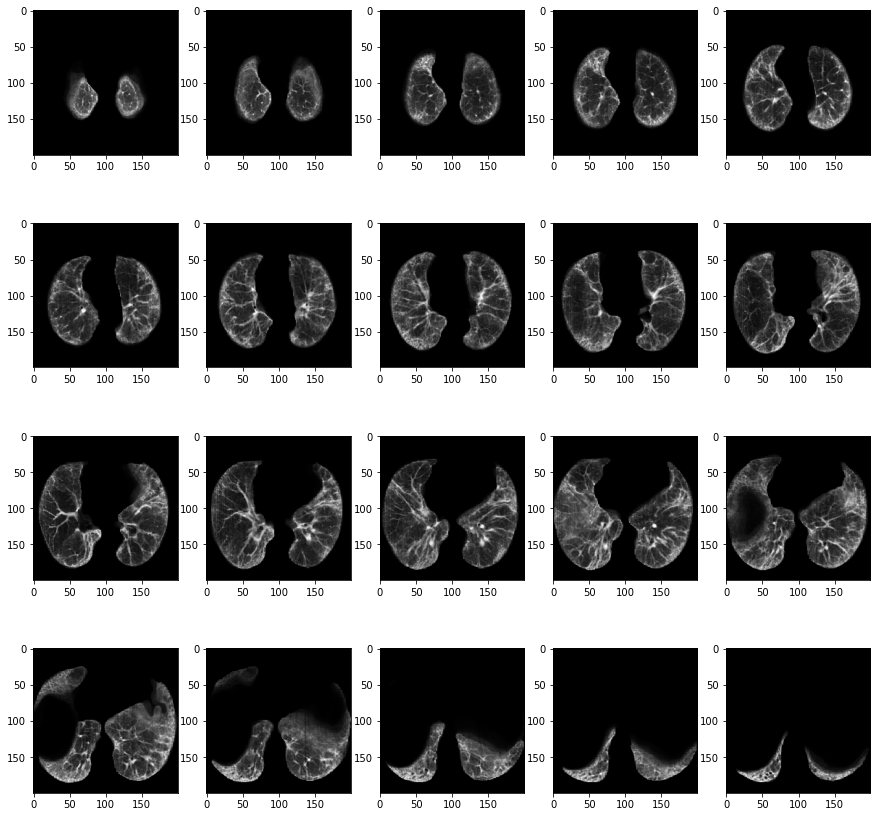

In [11]:
fig = plt.figure(figsize=[15,15])
for i in range(20):
    y = fig.add_subplot(4,5,i+1)
    y.imshow(ctdf['ct'][150][i], cmap='gray')